# Сложность алгоритмов и их оптимизация (сортировка подсчётом)

Пусть $A$ — входной массив чисел, $n$ — размер входного массива, $k$ — $max(A) - min(min(A), 0)$

Сложность алгоритма равна $O(n + k)$:
1. $n$ итераций для подсчёта количества повторений каждого уникального элемента входного массива;
2. $k$ итераций по массиву с счётчиками для восстановления отсортированного массива.

Используемая дополнительная память $O(k)$:
1. Для хранения счётчиков выделяется массив размера $k$.

## Тестирование реализаций алгоритмов

In [1]:
!pytest -q

..                                                                       [100%]
2 passed in 67.05s (0:01:07)


## Импортирование библиотек

In [1]:
import time
import tracemalloc

import matplotlib.pyplot as plt
import numpy as np
from src.bubble_sort import bubble_sort, jit_bubble_sort
from src.counting_sort import (counting_sort, jit_counting_sort,
                               jit_optimized_counting_sort,
                               optimized_counting_sort)


# set figure size
plt.rcParams["figure.figsize"] = (30, 10)

## Реализация функций для проведения экспериментов

In [3]:
def run_experiment(algo: callable, min_int: int, max_int: int, arr_size: int,
                   trials: int = 10) -> tuple[float, float, float]:
    """Run provided sorting algotithm $trials$ times on generated arrays with given parameters for 
    uniform integer distribution and return corresponding averaged wall time, cpu time and maximum memory usage.

    Args:
        algo (callable): sorting algorithm;
        min_int (int): minimum int in uniform distribution to generate testing arrays;
        max_int (int): maximum int in uniform distribution to generate testing arrays;
        arr_size (int): array size to test.
        trials (int, optional): runs quantity. Defaults to 10.

    Returns:
        tuple[float, float, float]: averaged wall time, cpu time, maximum memory usage.
    """
    all_wall_time = 0
    all_cpu_time = 0
    all_max_memory = 0
    
    tracemalloc.start()
    for seed in range(trials):
        np.random.seed(seed)
        arr = np.random.randint(min_int, max_int, size=arr_size)
        start_wall_time = time.time()
        start_cpu_time = time.process_time()
        tracemalloc.clear_traces()
        _ = algo(arr)
        all_max_memory += tracemalloc.get_traced_memory()[1]
        all_wall_time += (time.time() - start_wall_time)
        all_cpu_time += (time.process_time() - start_cpu_time)
    tracemalloc.stop()
    
    return all_wall_time / trials, all_cpu_time / trials, all_max_memory / trials
    

def run_research(algos: list[callable], min_int: int, max_int: int, array_sizes: list[int]) -> None:
    """Test provided sorting algorithms and build plots with corresponding wall time, cpu time, and memory usage.

    Args:
        algos (list[callable]): list of sorting algorithms;
        min_int (int): minimum int in uniform distribution to generate testing arrays;
        max_int (int): maximum int in uniform distribution to generate testing arrays;
        array_sizes (list[int]): list of arrays sizes to test.
    """
    algo_metrics = {}
    
    for algo in algos:
        algo_metrics[algo] = {
            'wall_times': [],
            'cpu_times': [],
            'max_memory_usages': []
        }
        for arr_size in array_sizes:
            avg_wall_time, avg_cpu_time, avg_max_memory = run_experiment(algo, min_int, max_int, arr_size)
            algo_metrics[algo]['wall_times'].append(avg_wall_time)
            algo_metrics[algo]['cpu_times'].append(avg_cpu_time)
            algo_metrics[algo]['max_memory_usages'].append(avg_max_memory)
    
    plt.subplot(1, 3, 1)
    for algo in algos:
        plt.plot(array_sizes, algo_metrics[algo]['wall_times'],
                 label=algo.__name__)
    plt.title('Wall Time')
    plt.xlabel('Array size')
    plt.ylabel('Seconds')
    plt.legend(loc='best')
    
    plt.subplot(1, 3, 2)
    for algo in algos:
        plt.plot(array_sizes, algo_metrics[algo]['cpu_times'],
                 label=algo.__name__)
    plt.title('CPU Time')
    plt.xlabel('Array size')
    plt.ylabel('Seconds')
    
    plt.subplot(1, 3, 3)
    for algo in algos:
        plt.plot(array_sizes, algo_metrics[algo]['max_memory_usages'],
                 label=algo.__name__)
    plt.title('Max memory usage in bytes')
    plt.xlabel('Array size')
    plt.ylabel('Max memory usage in bytes')

## Сравнение реализаций сортировки подсчётом и сортировкой пузырьком

На графике ниже (Wall Time, CPU Time) можно заметить, что для $n > \sim 1.5k$ реализация сортировки подсчётом заметно быстрее реализации сортировки пузырьком. Также стоит отметить, что количество максимально используемой памяти практически не изменяется для сортировки пузырьком и возврастает для сортировки подсчётом. Последнее, возможно, связано со спецификой хранения значений numpy.float64, которые по умолчанию используются для инициализации массива счётчика.

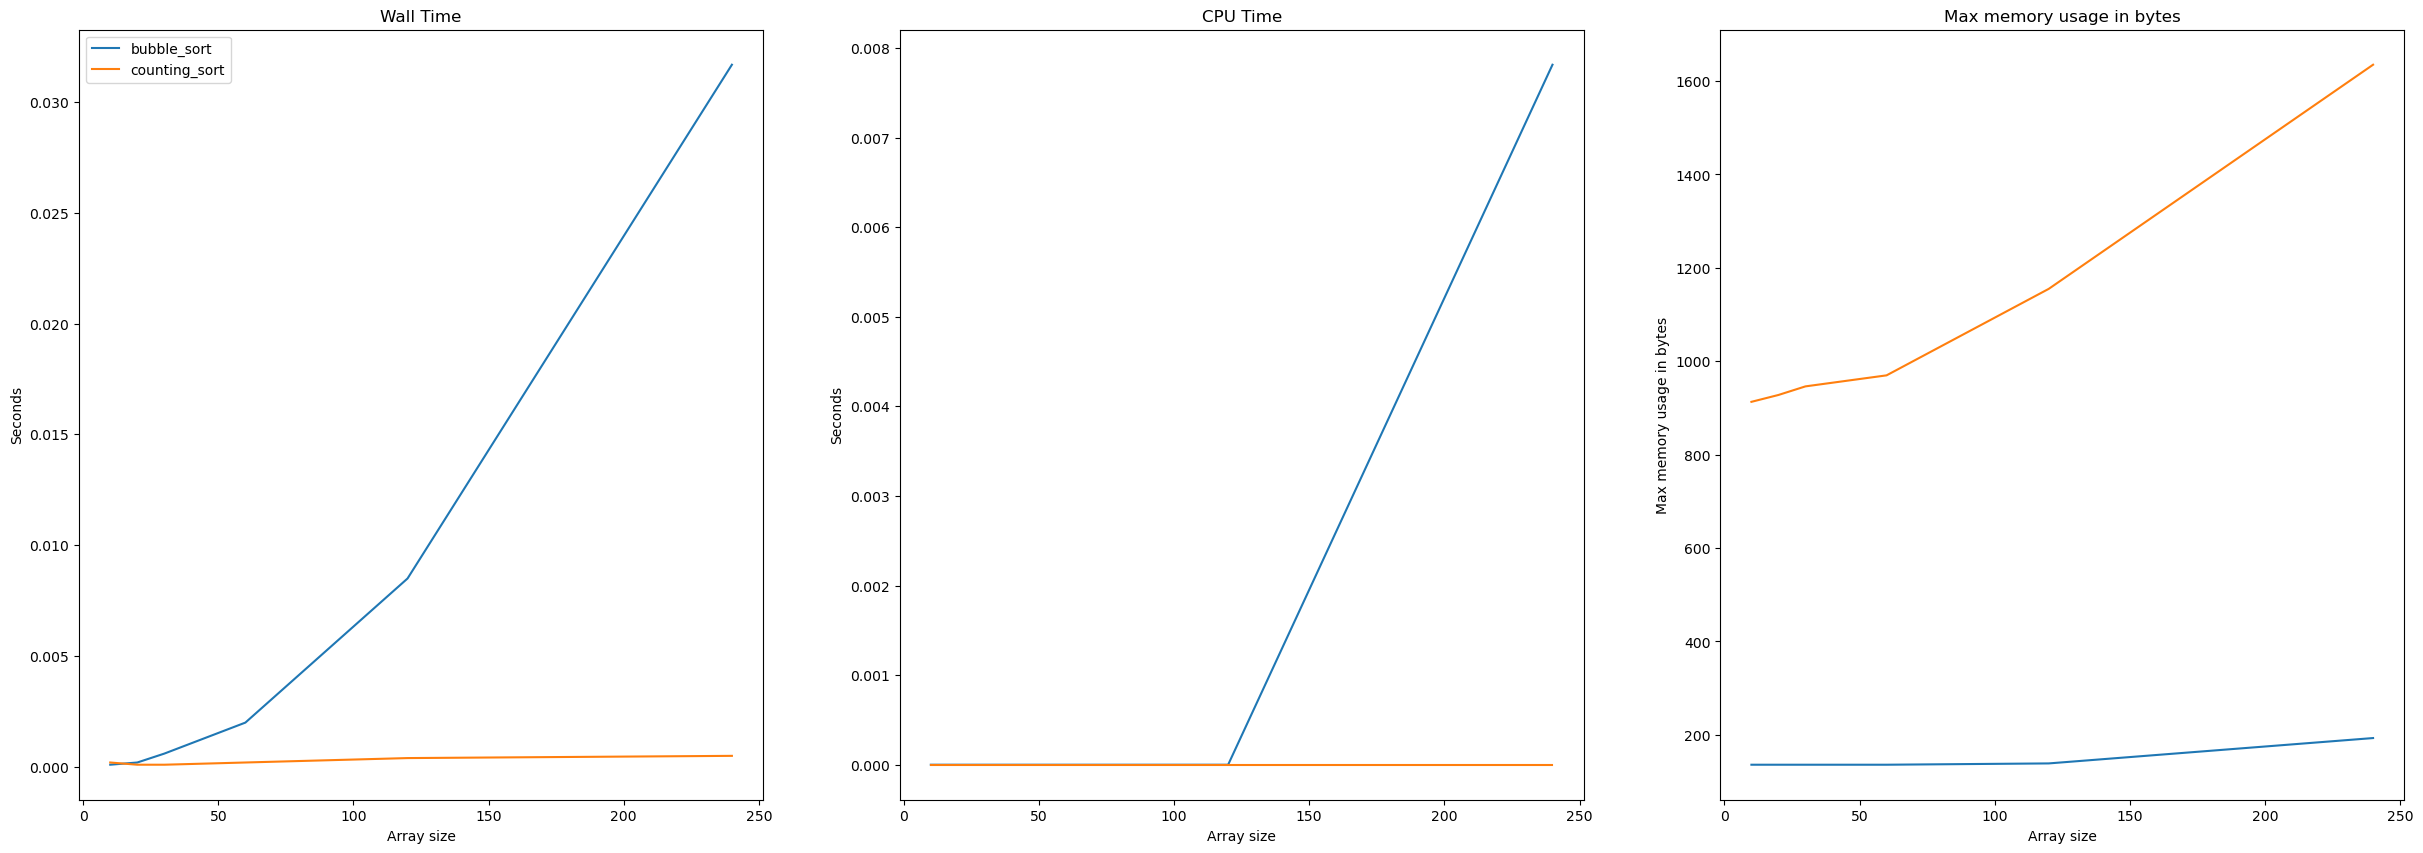

In [15]:
run_research(algos = [bubble_sort, counting_sort],
             min_int = -10,
             max_int = 10,
             array_sizes = [10, 20, 30, 60, 120, 240])

На графике ниже можно заметить, что несмотря на потенциально большой $k$ (вплоть до $40000$), при $n > 500$ сортировка подсчётом быстрее сортировки пузырьком. Однако, стоит отметить, что сортровка подсчётом при этом требует значительно больше памяти в сравнении с сортировкой пузырьком.

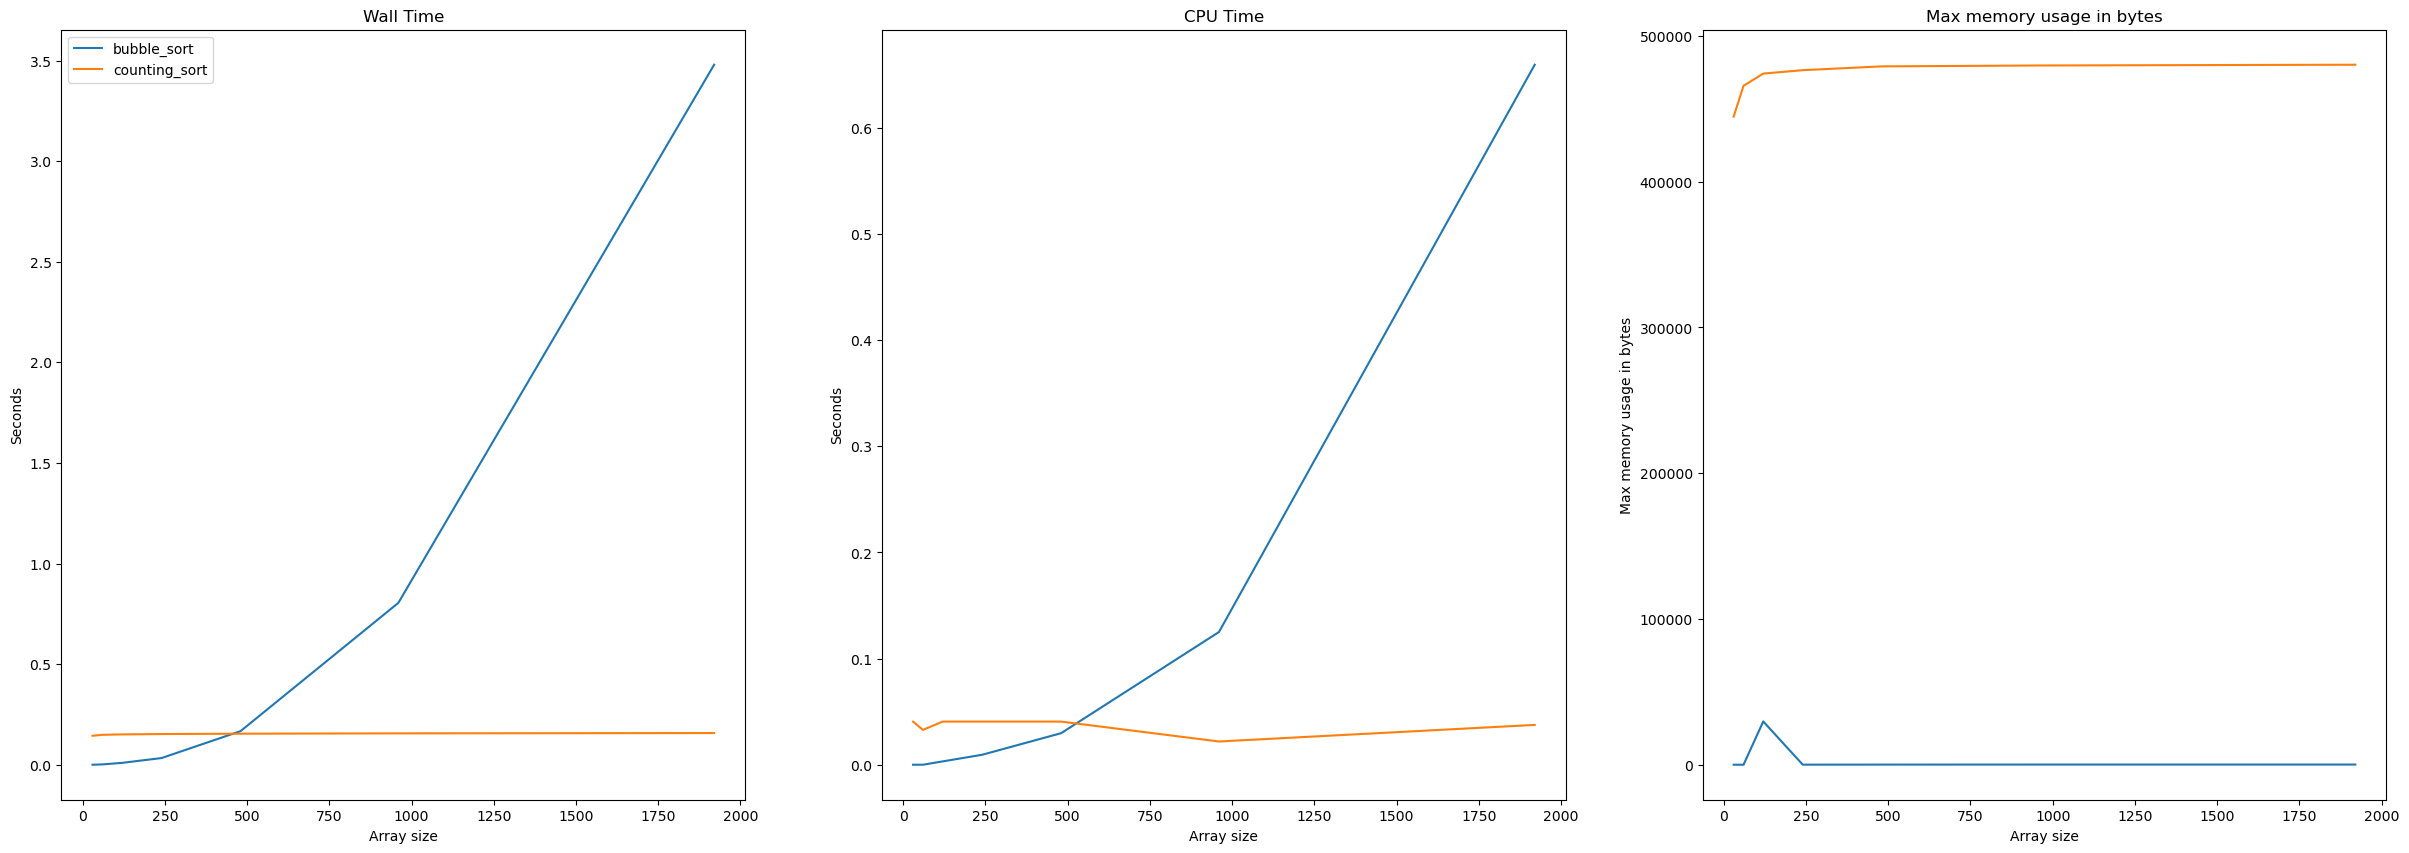

In [16]:
run_research(algos = [bubble_sort, counting_sort],
             min_int = -20000,
             max_int = 20000,
             array_sizes = [30, 60, 120, 240, 480, 960, 1920])

На графике ниже можно заметить, что при $n > \sim k$ использование памяти данной реализацией сортировки подсчётом начинает заметно расти.

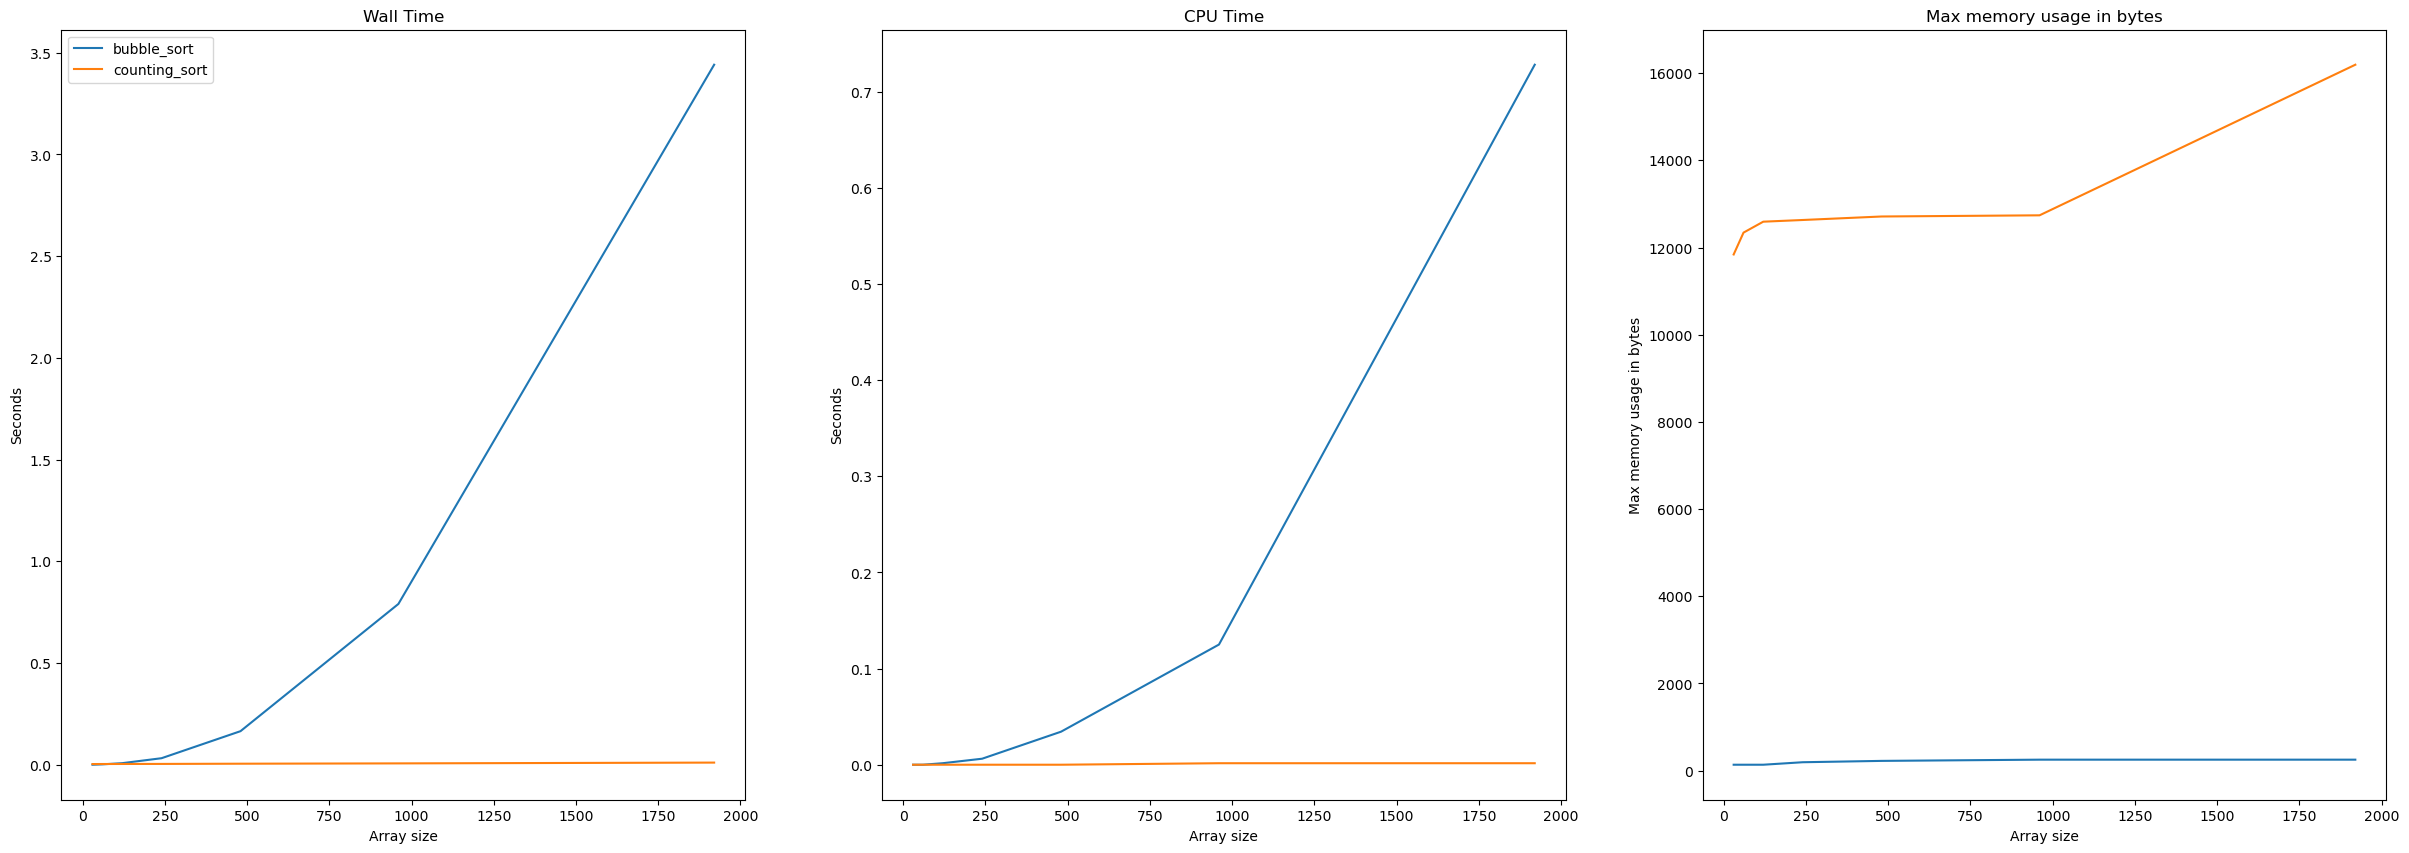

In [17]:
run_research(algos = [bubble_sort, counting_sort],
             min_int = -500,
             max_int = 500,
             array_sizes = [30, 60, 120, 240, 480, 960, 1920])

## Оптимизирование сортировки подсчётом

Сперва была произведена оптимизация алгоритма при помощи Numba (на графике jit_counting_sort). Можно заметить, что скорость работы значительно возросла. При этом, максимальное потребление памяти также увеличилось. 

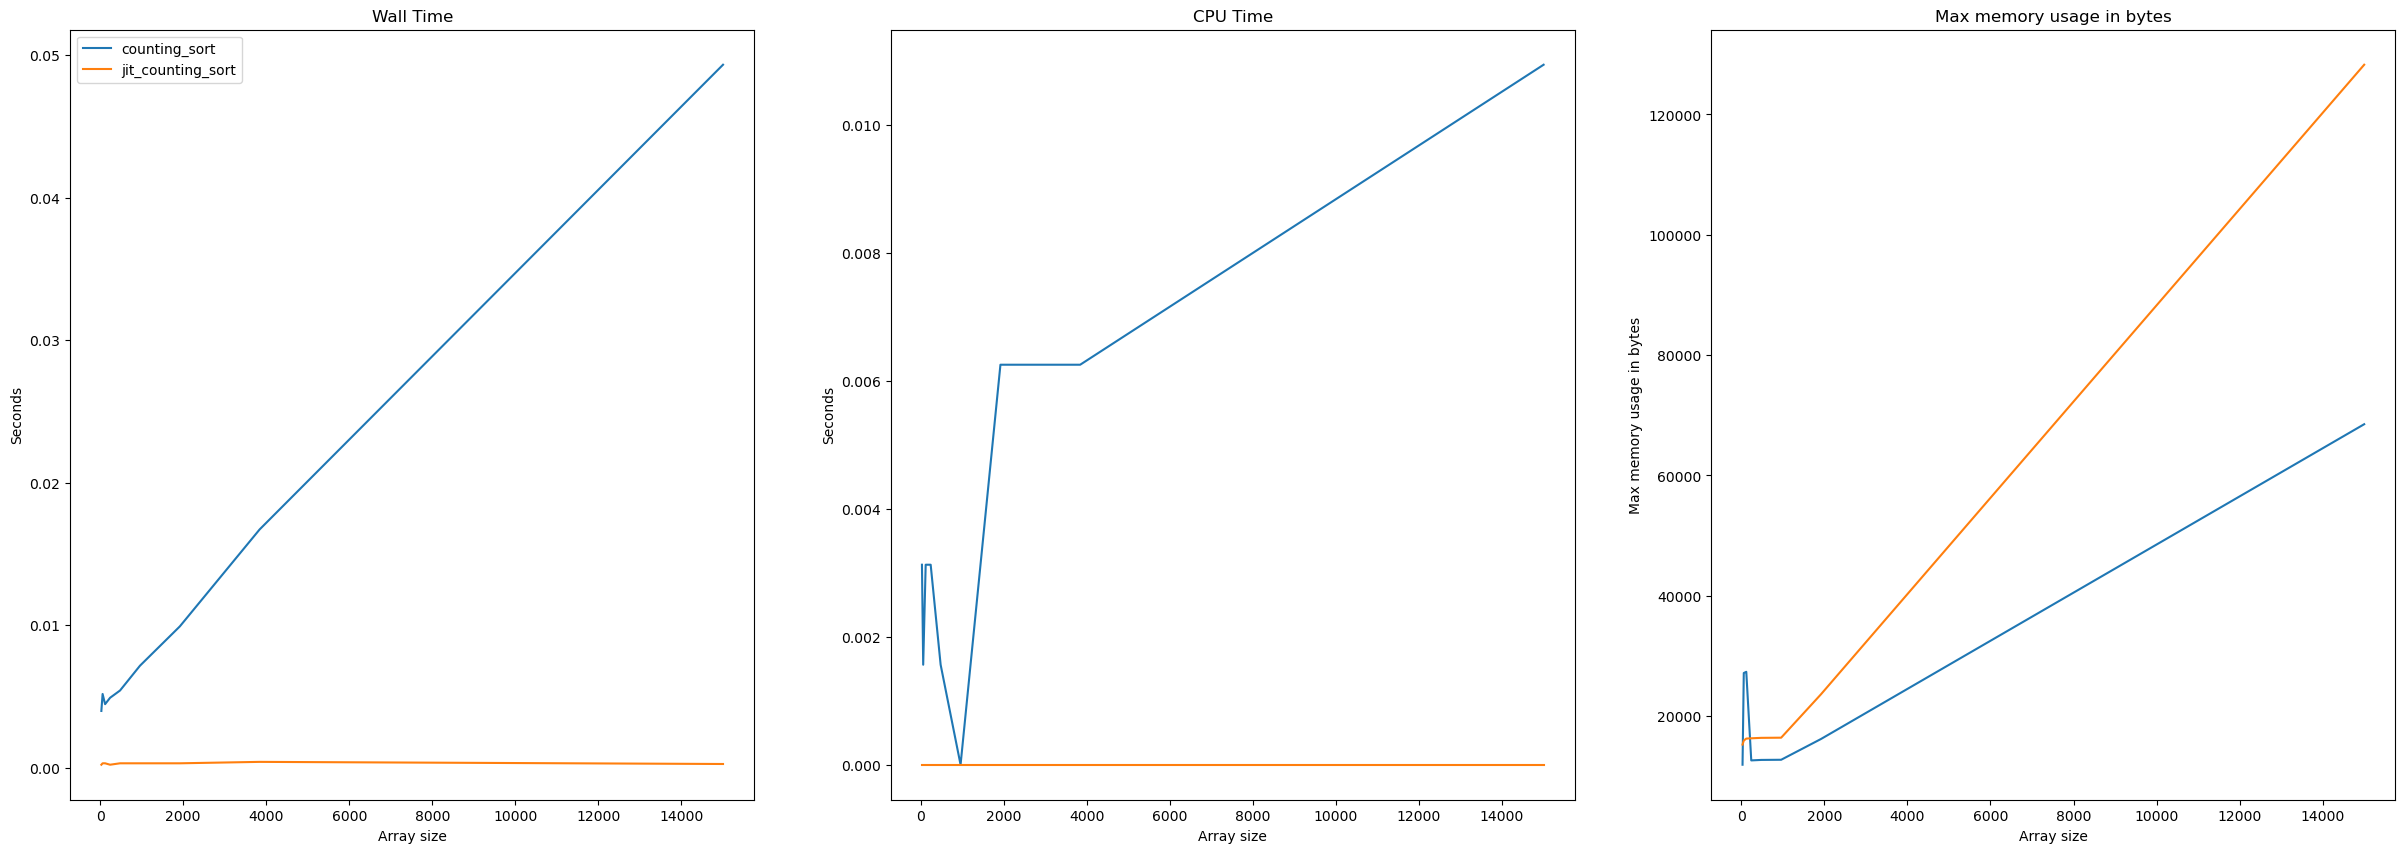

In [9]:
run_research(algos = [counting_sort, jit_counting_sort],
             min_int = -500,
             max_int = 500,
             array_sizes = [30, 60, 120, 240, 480, 960, 1920, 3840, 15000])

Затем была произведена модификация алгоритма сортировки подсчётом (optimized_counting_sort). Для этого:
1. Во время инициализации для np.zeros устанавливается dtype np.uint32.
2. Восстановление отсортированного массива из массива счётчиков производится через "срезы".

Можно заметить, что время работы модифицированного алгоритма либо чуть-чуть ухудшилось, либо осталось приблизительно тем же. Однако, удалось сократить размер потребляемой алгоритмом памяти.

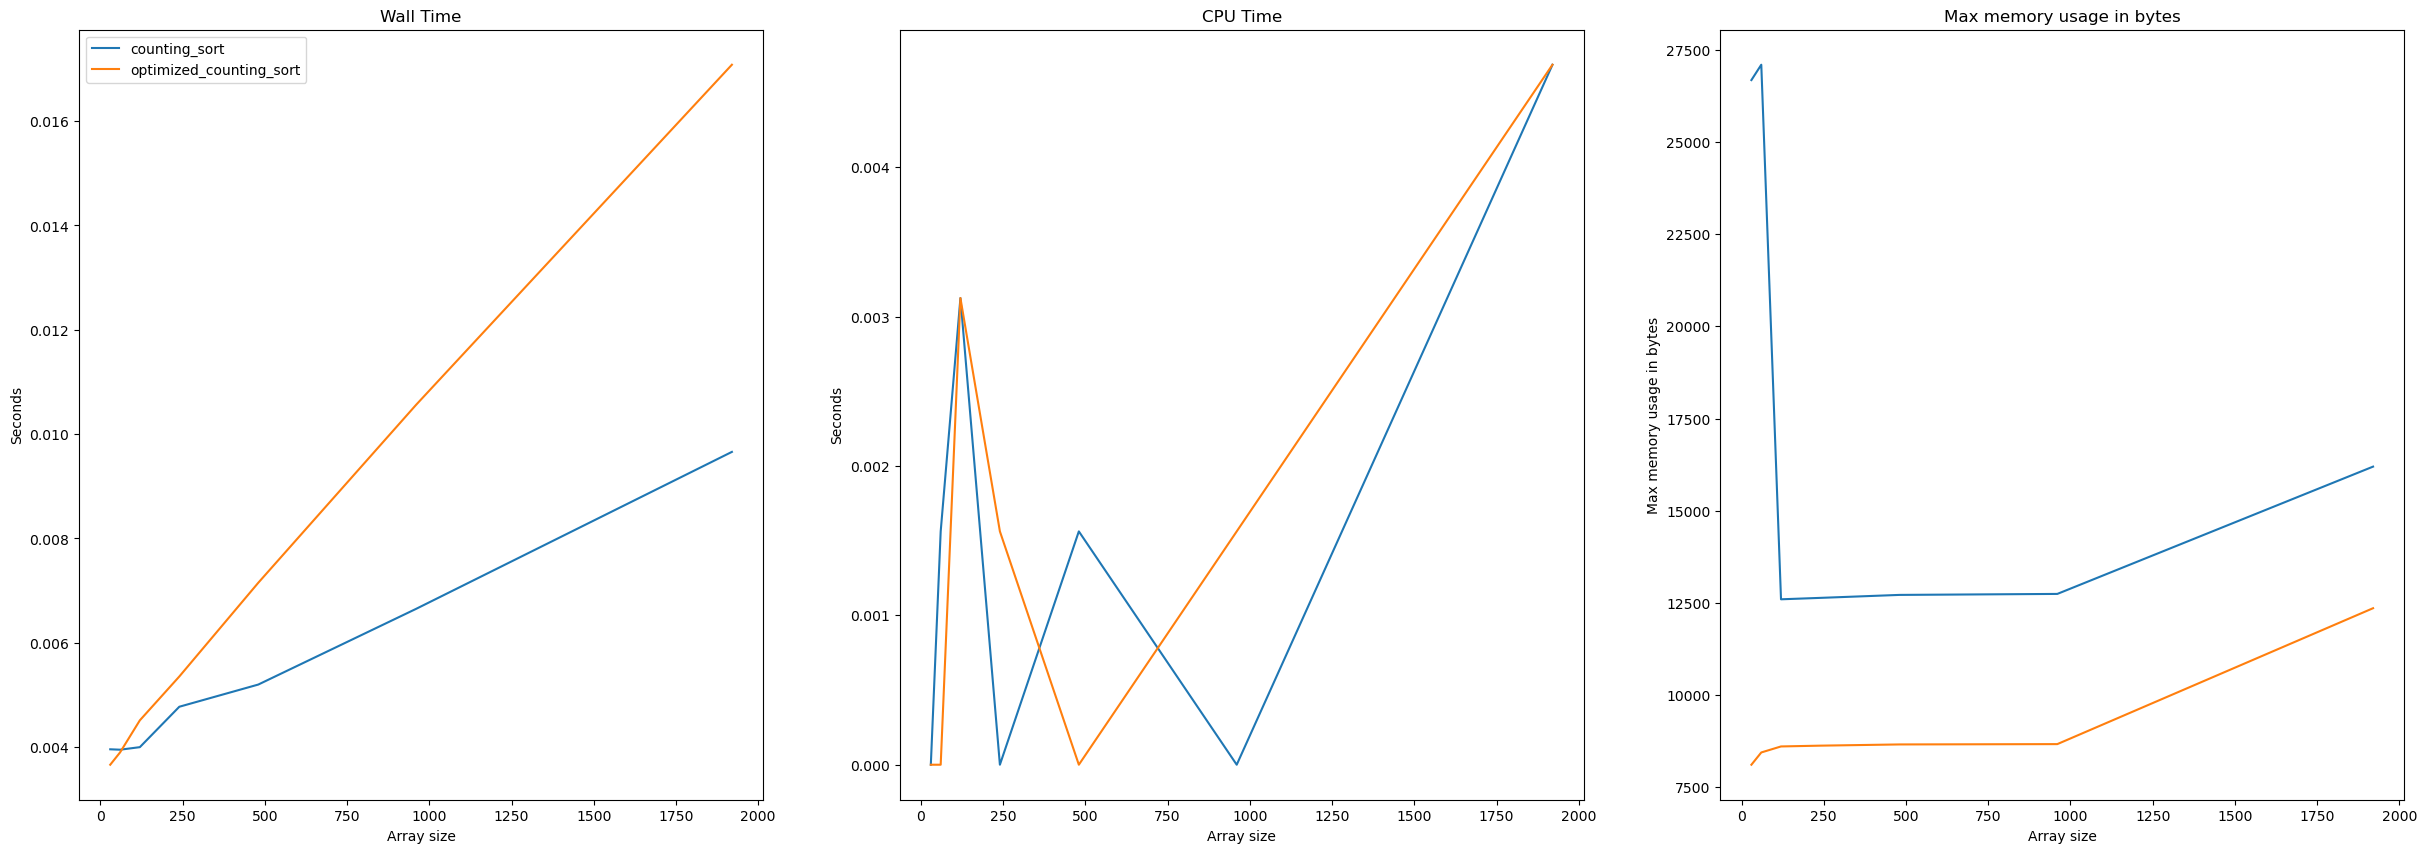

In [10]:
run_research(algos = [counting_sort, optimized_counting_sort],
             min_int= -500,
             max_int = 500,
             array_sizes = [30, 60, 120, 240, 480, 960, 1920])

Теперь сравним обе реализации, оптимизированные при помощи Numba. Можно заметить, что модифицированная сортировка подсчётом заметно быстрее и потребляет меньше памяти.

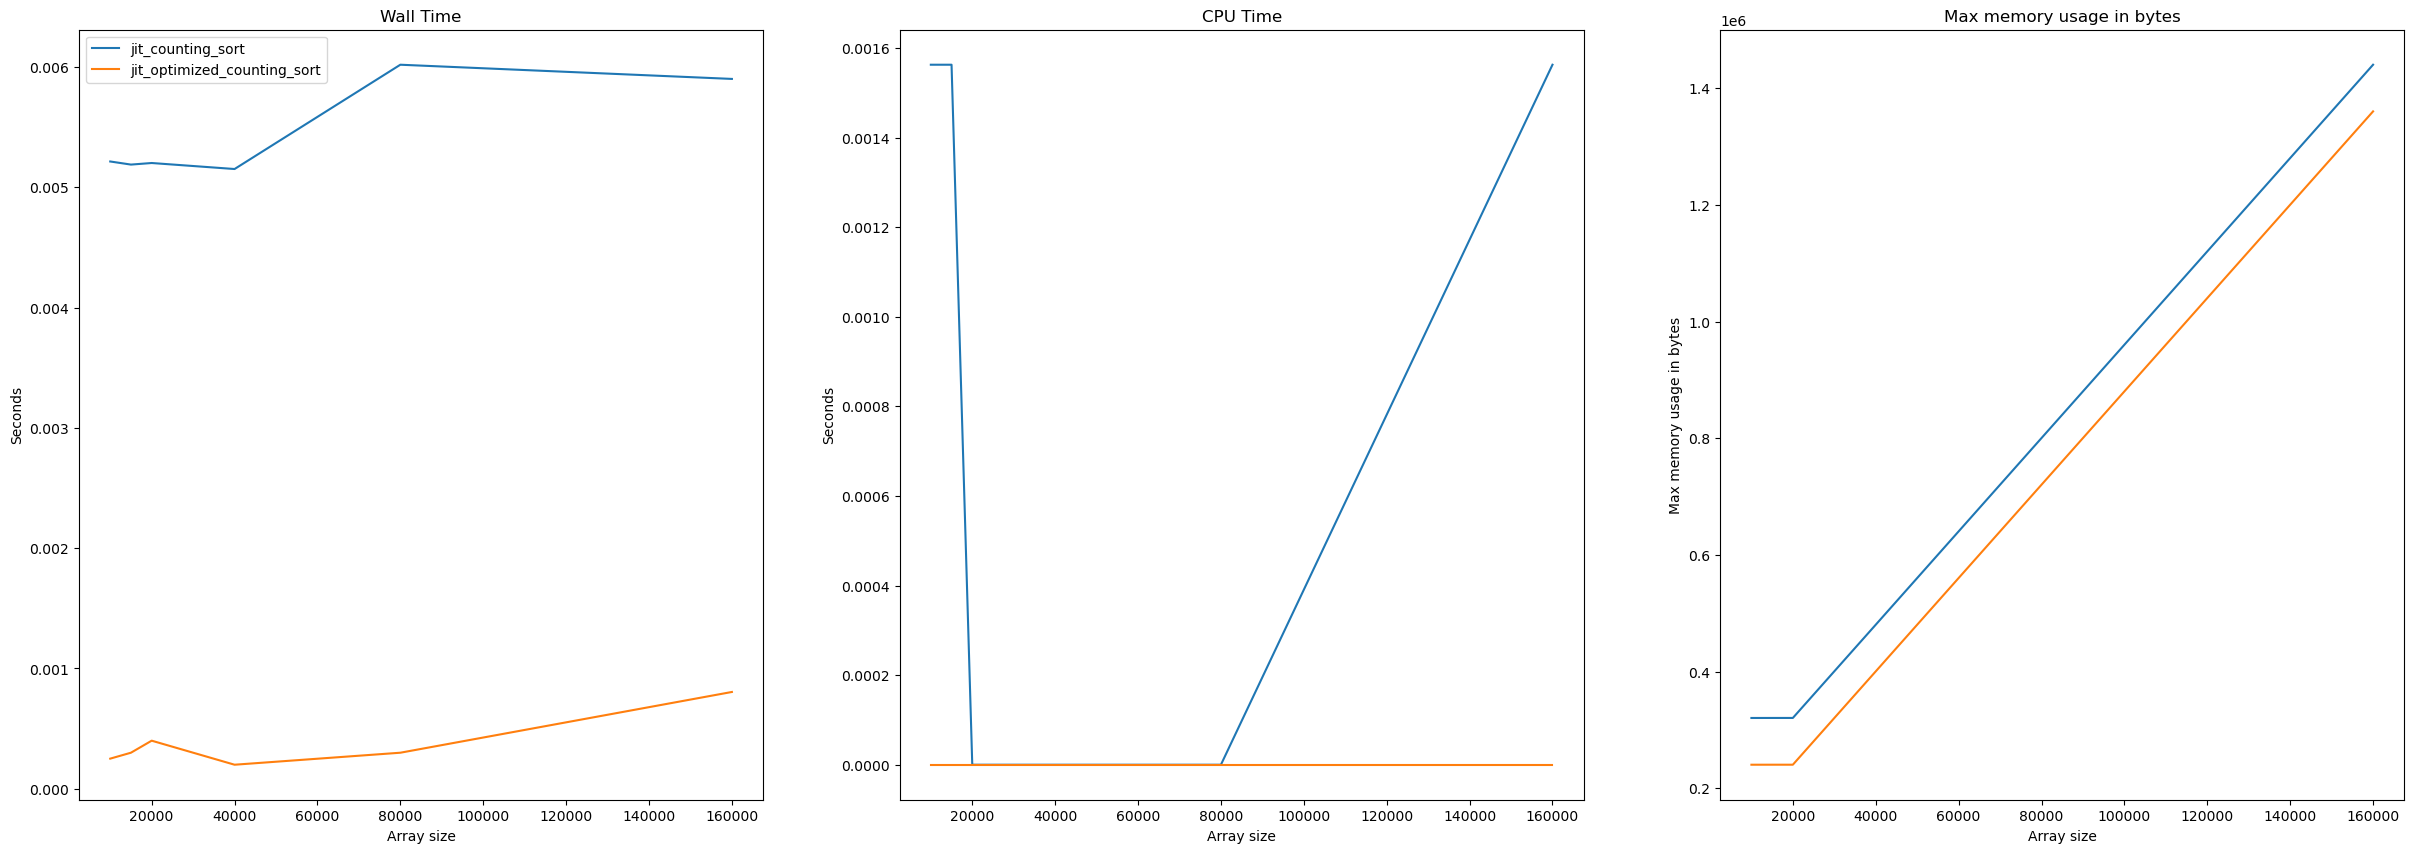

In [17]:
run_research(algos = [jit_counting_sort, jit_optimized_counting_sort],
             min_int = -10000,
             max_int = 10000,
             array_sizes = [10000, 15000, 20000, 40000, 80000, 160000])

## Выводы

1. Алгоритм сортировки подсчётом является эффективным алгоритмом по времени работы. Однако, при больших $n$ и $k$ может потребоваться значительный объём дополнительной памяти.
2. Применив Numba, можно значительно ускорить время работы алгоритма.
3. Контроль типов данных в Numpy может привести к снижению потребляемой алгоритмом памяти.